>>>[5.1 Trivial Implementation](#folderId=1NMmMD5RX97aCsXDtRdiTFytxzVFeGSnW&updateTitle=true&scrollTo=-TLcDZv9QLDV)

>>>[5.3 Analyzing the Algorithm](#folderId=1NMmMD5RX97aCsXDtRdiTFytxzVFeGSnW&updateTitle=true&scrollTo=jnDBhClMVdlo)

>>>>[How is the length of the inout message affecting the speed of encrypting and decrypting?](#folderId=1NMmMD5RX97aCsXDtRdiTFytxzVFeGSnW&updateTitle=true&scrollTo=bNram5eGVnEZ)



In [26]:
import random
import math
import requests
import time
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt

IS_GOOGLE_COLAB=True

To better understand the practical application of the theoretical principles we've discussed, let's walk through the key generation, encryption, and decryption processes involved in the RSA algorithm. For the sake of clarity, we'll use small numbers as the previous math example.

### 5.1 Trivial Implementation

First let't prepare the functions that will be needed to perform the 5 steps of the key generaiton process.

Generate prime numbers

In [64]:
def is_prime (number):
    if number < 2:
        return False
    for i in range (2, number // 2 + 1):
        if number % i == 0:
            return False
    return True

# 🔴add a check here if random number is not found in the given range
def generate_prime (min_value, max_value):
    # prime = random.randint (min_value, max_value)
    # while not is_prime(prime):
    #     prime = random.randint(min_value, max_value)

    # if (is_prime(prime)):
    #     return prime

    """Return a random prime number in the given range using brute force."""
    if min_value > max_value:
        raise Exception(f"Invalid range [{min_value}; {max_value}]")

    all_numbers = set(range(min_value, max_value + 1))
    checked_numbers = set()

    while all_numbers:
        number = random.choice(list(all_numbers))
        all_numbers.remove(number)
        checked_numbers.add(number)

        if is_prime(number):
            return number

    raise Exception(f"No prime number in the range [{min_value}; {max_value}]")

Generate $\varphi(n)$

In [3]:
def eulers_totient(p, q):
    return (p-1) * (q-1)

Generate public exponent $e$

In [4]:
def generate_public_exponent(phi_n):
    e = random.randint (3, phi_n-1)
    while math.gcd(e, phi_n) != 1:
        e = random.randint (3, phi_n - 1)

    return e

Calculate the modular inverse $d$

In [5]:
def mod_inverse(e, phi):
    for d in range (3, phi):
        if (d * e) % phi == 1:
            return d
    raise ValueError ("Mod_inverse does not exist!")

Now let's combine the above helper functions to generate the public and private keys. The function `generate_keys` will also return $n$, which will be used in subsequent encryption/decryption.

Generate keys

In [46]:
def generate_keys(p = None, q = None, e = None):
    # Step 1: Generate primes
    if ((not p) or (not q)):
        p, q = generate_prime(1000, 3000), generate_prime (3000, 6000)
    else:
        if (not is_prime (p) or not is_prime(q)):
            pass

    #step 2: Generate the product of the primes
    n = p * q

    # Step 3: Generate φ(n)
    phi_n = eulers_totient(p, q)

    # step 4: Generate the public exponent e
    if (not e):
        e = generate_public_exponent(phi_n)

    # Step 5: Calculate the modular inverse d
    d = mod_inverse(e, phi_n)

    return e, d, n

Encrypt/Decrypt the message

In [7]:
def encrypt_message_to_cipher(M, e, n):
    M_ascii_encoded = [ord(ch) for ch in M]
    cipher = [pow(ch, e, n) for ch in M_ascii_encoded]

    return cipher

def decrypt_cipher_to_message(C, d, n):
    C_ascii_encoded = [pow(ch, d, n) for ch in C]
    M = "".join (chr(ch) for ch in C_ascii_encoded)

    return M

Put together all pieces to show the RSA algorithm

In [8]:
e, d, n = generate_keys()

message = "A"
encrypted = encrypt_message_to_cipher(message, e, n)
decrypted = decrypt_cipher_to_message(encrypted, d, n)

print ("Public Key:  ", e)
print ("Private Key: ", d)
print ("n:           ", n)
print ("Original message:  ", message)
print ("Encrypted by RSA   ", encrypted)
print ("Decrypted message: ", decrypted)

Public Key:   1303375
Private Key:  6610255
n:            9287039
Original message:   A
Encrypted by RSA    [7977545]
Decrypted message:  A


Now is a good time to write some test so that we know we haven't broken our implementation with future changes of the code.

In [9]:
def test_decrypting(message):
    e, d, n = generate_keys()
    encrypted = encrypt_message_to_cipher(message, e, n)
    decrypted = decrypt_cipher_to_message(encrypted, d, n)
    assert decrypted == message, "The decrypted message is not the same as the original message!"

def all_unit_tests(messages):
    for message in messages:
        test_decrypting(message)

    print("All tests passed")

In [61]:
file_6000_chars=""

if IS_GOOGLE_COLAB == True:
    file_6000_chars = requests.get("https://raw.githubusercontent.com/MirkaIvanova/public_data/main/text_5832_chars.txt")
else:
    raise FileNotFoundError("FIXME!")
all_unit_tests(["A", "AB", "Hello and welcome to Sofia!", file_6000_chars.text])

All tests passed


### 5.3 Analyzing the Algorithm

In this section, we will explore the impact of modifying various parameters involved in the RSA algorithm, particularly focusing on how these changes affect security and performance.

First, let's define a helper decorator that executes the function it decorates n times and returns the average execution time in milliseconds. This will allow us to measure the performance of different parts of RSA.

🔴 maybe better to put it in external script?

In [11]:
def mean_time_msec(loops=1000):
    """
    A decorator that measures the mean execution time of a function over n executions.

    Input: loops (int): The number of times to execute the function. Defaults to 1000.
    Returns: function: A wrapper function that executes the given function n times and measures its mean execution time in milliseconds.
    """
    def decorator(func):
        @wraps(func)
        def timeit_wrapper(*args, **kwargs):
            total_time = 0
            start_time = time.perf_counter()
            for _ in range(loops):
                func(*args, **kwargs)
            end_time = time.perf_counter()
            total_time = end_time - start_time
            mean_time_msec = (total_time / loops) * 1000
            return mean_time_msec
        return timeit_wrapper
    return decorator

#### How the size of $p$ and $q$ affect the time for their generation?

Let's explore the time required to generate prime numbers of varying lengths. We will generate specific primes by constraining the range to the desired prime. The current algorithm employs a brute-force approach, generating a random number within a specified range and then checking its primality using a brute-force method.

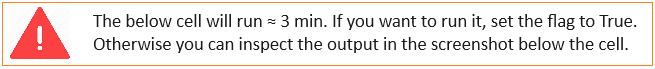

In [77]:
I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME = False

if I_UNDERSTAND_THE_CELL_WILL_RUN_LONG_TIME:
    # this is a list of primes that we will try to generate by giving
    # a range with equal lower and upper boundary, ex: [1009; 1009]
    ranges = [1009, 10007, 100003, 1000003, 10000019, 100_000_007, 1000000007]

    times_to_generate_prime = [mean_time_msec(3)(generate_prime)(boundary, boundary) for boundary in ranges]

    print(times_to_generate_prime)

Output of the above cell: 🔴

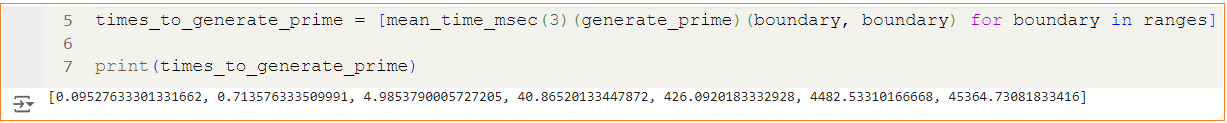

The prime number 1000000007 took $≈$ 45 seconds to generate. clearly a performance hog! Let's try to improve the performance by using another algorithm like the Sieve of Eratosthenes.

[0.09527633301331662, 0.713576333509991, 4.9853790005727205, 40.86520133447872, 426.0920183332928, 4482.53310166668, 45364.73081833416]

In [82]:
# 🔴 external script file!
def generate_prime_sieve_eratosthenes(lower, upper):
    """
    Generate a random prime number within a specified range using the Sieve of Eratosthenes algorithm.

    Parameters:
    lower (int): The lower bound of the range (inclusive).
    upper (int): The upper bound of the range (inclusive).

    Returns:
    int: A random prime number within the specified range.
    """
    if lower > upper:
        raise ValueError("Lower bound must be less than or equal to the upper bound.")

    if upper < 2:
        raise ValueError("Upper bound must be at least 2 to include any prime numbers.")

    # Use Sieve of Eratosthenes to find all primes up to the upper bound
    sieve = [True] * (upper + 1)
    sieve[0] = sieve[1] = False  # 0 and 1 are not prime numbers

    for number in range(2, int(upper ** 0.5) + 1):
        if sieve[number]:
            for multiple in range(number * number, upper + 1, number):
                sieve[multiple] = False

    # Extract primes within the specified range
    primes_in_range = [num for num in range(max(2, lower), upper + 1) if sieve[num]]

    if not primes_in_range:
        raise ValueError(f"No prime numbers found in the range {lower} to {upper}.")

    # Select a random prime from the list
    return random.choice(primes_in_range)

# Example usage:
lower, upper = 1_000_000_007, 1_000_000_007
print(f"Random prime number between {lower} and {upper}: {random_prime_in_range(lower, upper)}")


Random prime number between 1000000007 and 1000000007: 1000000007


In [88]:
import random

def is_prime_miller_rabin(n, k=5):
    """Perform the Miller-Rabin primality test on n using k iterations."""

    # Helper function to perform modular exponentiation
    def power_mod(base, exp, mod):
        result = 1
        base = base % mod
        while exp > 0:
            if exp % 2 == 1:
                result = (result * base) % mod
            exp = exp >> 1
            base = (base * base) % mod
        return result

    # If n is less than 2, it is not prime
    if n < 2:
        return False

    # If n is 2 or 3, it is prime
    if n in (2, 3):
        return True

    # If n is even, it is not prime
    if n % 2 == 0:
        return False

    # Write n-1 as 2^r * d
    r, d = 0, n - 1
    while d % 2 == 0:
        d //= 2
        r += 1

    # Perform k rounds of testing
    for _ in range(k):
        a = random.randint(2, n - 2)
        x = power_mod(a, d, n)
        if x == 1 or x == n - 1:
            continue

        for _ in range(r - 1):
            x = power_mod(x, 2, n)
            if x == n - 1:
                break
        else:
            return False

    return True

Test the Miller-Rabin primality test

In [89]:
number = 1_000_000_007
is_prime = is_prime_miller_rabin(number, k=5)
print(f"{number} is {'a prime' if is_prime else 'not a prime'} number.")

1000000007 is a prime number.


We see from the above test that the largest number for which we tried brute-force, $1000000007$, is tested for primality in about a second. No need to be exact here, the difference between 1 and 45 seconds is huge.

So let's overwrite our original `is_prime` function and perform the perfomance test again.

In [90]:
is_prime = is_prime_miller_rabin

In [93]:
times_to_generate_prime_mr = [mean_time_msec(3)(generate_prime)(boundary, boundary) for boundary in ranges]
print(times_to_generate_prime_mr)

[0.05930866609560326, 0.03888366700266488, 0.05228399944220049, 0.057410333586934335, 0.0763120006013196, 0.09055699896028575, 0.09836099949704173]


Test the time it take to encrypt and decrypt messages of different lengths and plot the result:

[4.1660659000626765, 210.36519419994875, 267.29653570000664, 354.05392960001336, 566.9560950000232, 646.6634264001186, 839.0653161000955, 944.47634320004, 1333.4257253000033]
[5.828713299888477, 286.67946819987264, 329.01897949996055, 491.8497130000105, 796.5247254000133, 930.5771964998712, 1022.2334482999939, 1557.2611799998413, 2054.399719399953]


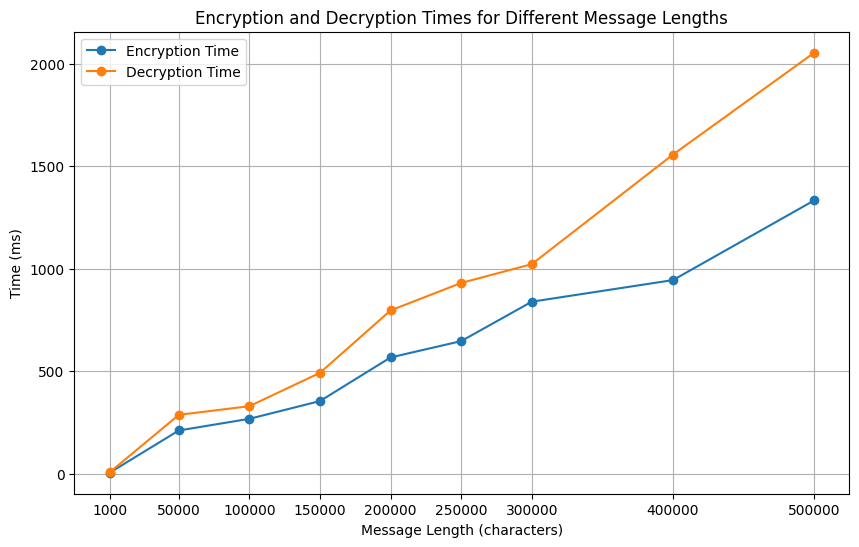

In [33]:
# OLD: #### How is the length of the input message affecting the speed of encrypting and decoding?
message_lengths = [1000, 50_000, 100_000, 150_000, 200_000, 250_000, 300_000, 400_000, 500_000]

long_text=""
if IS_GOOGLE_COLAB == True: # 🔴
    response = requests.get("https://raw.githubusercontent.com/MirkaIvanova/public_data/main/a_tale_of_two_cities_780000_chars.txt")
    long_text = response.text
else:
    raise FileNotFoundError("FIXME!")

long_text[:5]

e, d, n = generate_keys()

input_messages = [long_text[:n] for n in message_lengths]
encrypted_messages = [encrypt_message_to_cipher(message, e, n) for message in input_messages]
decrypted_messages = [decrypt_cipher_to_message(encrypted_message, d, n) for encrypted_message in encrypted_messages]

times_to_encrypt = [mean_time_msec(10)(encrypt_message_to_cipher)(message, e, n) for message in input_messages]
times_to_decrypt = [mean_time_msec(10)(decrypt_cipher_to_message)(encrypted_message, d, n) for encrypted_message in encrypted_messages]

print(times_to_encrypt)
print(times_to_decrypt)



plt.figure(figsize=(10, 6))
plt.plot(message_lengths, times_to_encrypt, marker='o', label='Encryption Time')
plt.plot(message_lengths, times_to_decrypt, marker='o', label='Decryption Time')

# Set the x-axis ticks to be proportionally spaced based on message_lengths
plt.xticks(message_lengths)

plt.xlabel('Message Length (characters)')
plt.ylabel('Time (ms)')
plt.title('Encryption and Decryption Times for Different Message Lengths')
plt.xticks(message_lengths)
plt.legend()
plt.grid(True)
plt.show()



